# 1. Install Dependencies and Setup

In [2]:
!pip install opencv-python matplotlib


  Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)


In [3]:
!pip install --upgrade pip



  Using cached pip-24.3.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2


In [4]:
!python3 --version


Python 3.12.7


In [5]:
import tensorflow as tf
import os


In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

physical_devices = tf.config.list_physical_devices()
print("Physical Devices:", physical_devices)

# Check for GPUs
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU detected!")
else:
    print("No GPU detected.")

Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU detected!


In [8]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# 2. Remove dodgy images

In [9]:
import cv2
import imghdr

In [10]:
data_dir = 'data' 

In [11]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [13]:
for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    
    # Skip non-directory files (e.g., .DS_Store or any other hidden files)
    if not os.path.isdir(class_dir):
        continue
    
    # Loop through images in each class
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)
        
        # Skip hidden files (e.g., .DS_Store)
        if image.startswith('.'):
            continue
        
        try:
            # Read the image
            img = cv2.imread(image_path)
            
            # Check the image file type
            tip = imghdr.what(image_path)
            
            if tip not in image_exts:
                print(f"Image not in allowed extensions: {image_path}")
                os.remove(image_path)  # Remove invalid image
        except Exception as e:
            print(f"Issue with image {image_path}: {e}")
            # Uncomment the next line if you want to delete problematic images
            # os.remove(image_path)

# 3. Load Data

In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [35]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 309 files belonging to 2 classes.


In [36]:
data_iterator = data.as_numpy_iterator()

In [37]:
batch = data_iterator.next()

In [38]:
batch[0].shape  # batch[0] represents the images and batch[1] represents the labels

(32, 256, 256, 3)

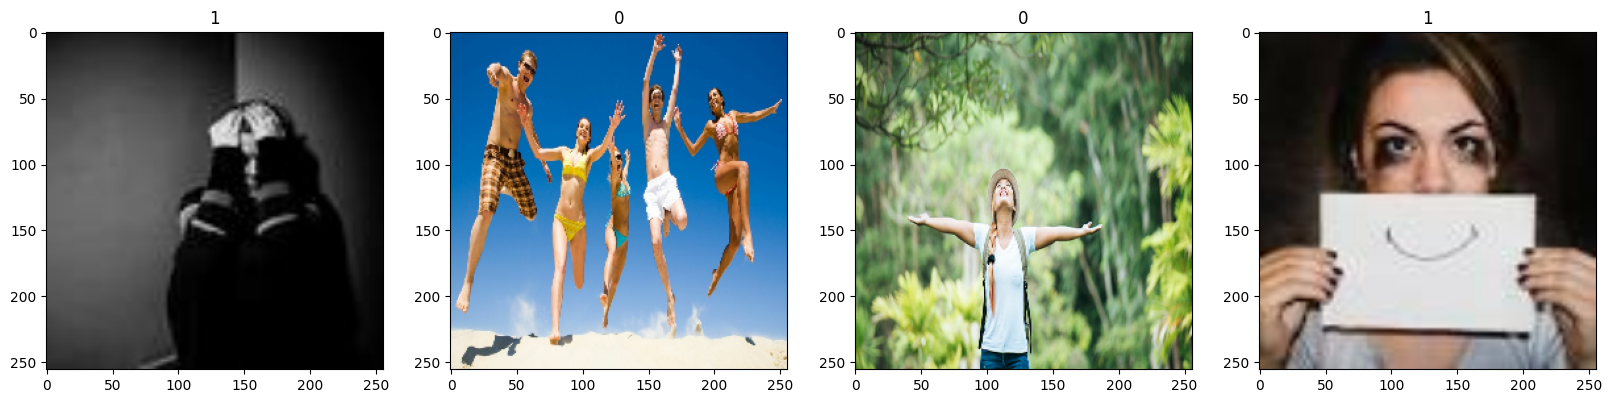

In [41]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [42]:
data = data.map(lambda x,y: (x/255, y))

In [45]:
scaled_batch = data.as_numpy_iterator().next()

In [47]:
scaled_batch[0].max()

1.0

# 5. Split Data

In [52]:
len(data)

10

In [53]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [54]:
print(train_size, val_size, test_size)

7 2 1


In [55]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [56]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [58]:
model = Sequential()

In [59]:
# Input layer with 16 filters of 3x3 and stride=1, input=height x width x no of channels(RGB=3, grayscale=1)
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# Output=254x254x16
model.add(MaxPooling2D())
# Output=127x127x16

model.add(Conv2D(32, (3,3), 1, activation='relu'))
# Output=125x125x16
model.add(MaxPooling2D())
# Output=62x62x16

model.add(Conv2D(16, (3,3), 1, activation='relu'))
# Output=60x60x16
model.add(MaxPooling2D())
# Output=30x30x16

model.add(Flatten())
# Output will be collapsed into one-dimensional vector of size 30x30x16=14400

# Fully connected dense layer, each of the 14400 inputs is connected to all 256 neurons
model.add(Dense(256, activation='relu'))
# weights=14400x256, biases=256, total_trainable_parameters=36,86,656

# Each of the 256 neurons from first layer connects to this one neuron in output layer
model.add(Dense(1, activation='sigmoid'))
# weights=256, bias=1, total_trainable_parameters=257

# total_trainable_parameters=36,86,656+257=36,86,913

/Users/ankit/ImageClassification/imageclassification/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [63]:
logdir='logs'

In [64]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [65]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2025-01-04 22:13:26.371521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.5813 - loss: 0.8907 - val_accuracy: 0.8281 - val_loss: 0.6439
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7551 - loss: 0.6617 - val_accuracy: 0.6094 - val_loss: 0.6493
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.6782 - loss: 0.6202 - val_accuracy: 0.5625 - val_loss: 0.6641
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.7550 - loss: 0.5496 - val_accuracy: 0.8281 - val_loss: 0.4352
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.8533 - loss: 0.4258 - val_accuracy: 0.8750 - val_loss: 0.4004
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.8679 - loss: 0.3820 - val_accuracy: 0.9219 - val_loss: 0.3144
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.8917 - loss: 0.3201 - val_accuracy: 0.9531 - val_loss: 0.2256
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9655 - loss: 0.2033 - val_accuracy: 0.9062 - val_loss: 0.2041
Epo

# 8. Plot Performance

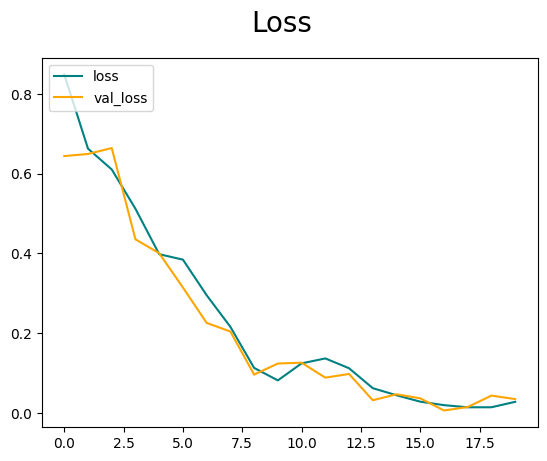

In [66]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

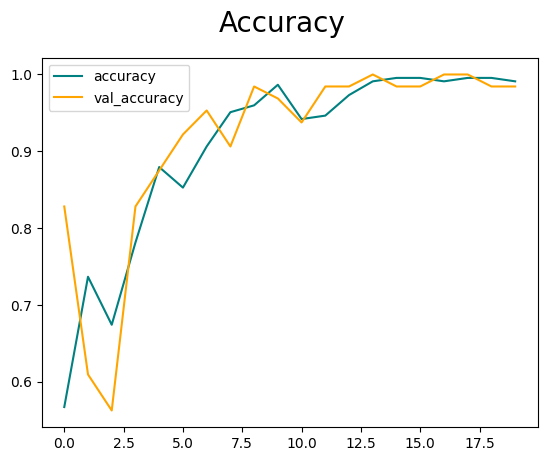

In [67]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [68]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [69]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [70]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


2025-01-04 22:39:45.162184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [72]:
print(f'Precision:{pre.result()}, Recall:{re.result()}, Accuracy:{acc.result()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


# 10. Test

In [73]:
import cv2

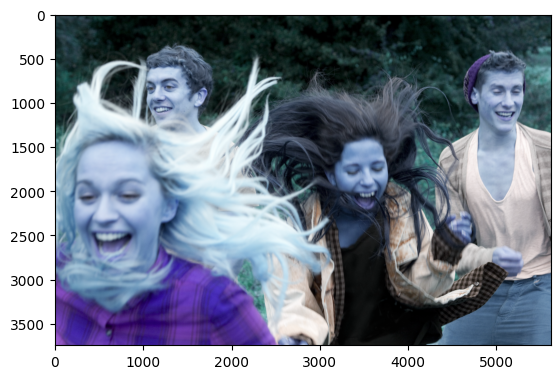

In [114]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

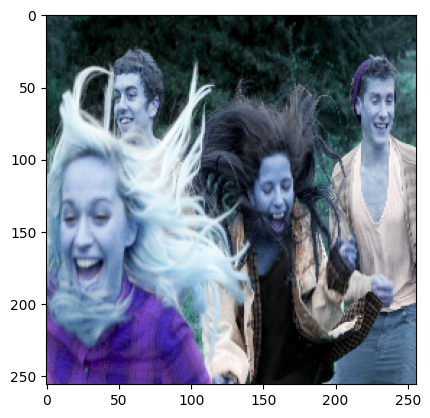

In [115]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [116]:
resize.shape

TensorShape([256, 256, 3])

In [117]:
np.expand_dims(resize, 0).shape # as our model take input in batches so we are expanding dimension

(1, 256, 256, 3)

In [118]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [119]:
yhat

array([[0.468415]], dtype=float32)

In [120]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [121]:
from tensorflow.keras.models import load_model

In [122]:
model.save(os.path.join('models','imageclassifier.h5'))

In [125]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [126]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


array([[0.468415]], dtype=float32)